Pablo Alejandro Méndez Morales #19195  
Jose Javier Hurtarte Hernández #19707  
# Laboratorio #6 - Clasificación de Malware con DL

In [83]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras import models
from keras import layers
from keras import optimizers
import plotly.express as px
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [42]:
data_location = "./malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = './selected/selected'

## Preprocesamiento
En el preprocesamiento debe mostrar cuantos ejemplares hay por cada familia. En base a estos datos debe determinar si considera pertinente prescindir de ejemplares que tengan pocas observaciones.

In [43]:
data = []
for family in os.scandir(data_location):
    if family.is_dir:
        for malware in os.scandir(family):
            width, height = Image.open(malware.path).size
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
                "width": width,
                "height": height,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family", "width", "height"])
df

,name,path,family,width,height
0,000bde2e9a94ba41c0c111ffd80647c2.png,./malimg_dataset/malimg_paper_dataset_imgs\Adi...,Adialer.C,512,410
1,000e30a0819ac7ed931d629ce2ef8948.png,./malimg_dataset/malimg_paper_dataset_imgs\Adi...,Adialer.C,512,409
2,002f06eff1d222560939be72583d6ae9.png,./malimg_dataset/malimg_paper_dataset_imgs\Adi...,Adialer.C,512,410
3,0044f0746b812f6b454ce210bc58c572.png,./malimg_dataset/malimg_paper_dataset_imgs\Adi...,Adialer.C,512,410
4,0046a83d932a3d431eb21a99b46d6af7.png,./malimg_dataset/malimg_paper_dataset_imgs\Adi...,Adialer.C,512,409
...,...,...,...,...,...
9334,08a76fe7517aca8a28ece24684855d1d.png,./malimg_dataset/malimg_paper_dataset_imgs\Yun...,Yuner.A,768,683
9335,08a9e75728b42c9b54a51f6619d8a174.png,./malimg_dataset/malimg_paper_dataset_imgs\Yun...,Yuner.A,768,683
9336,08acb94708c0dbb3ba53f6766d681453.png,./malimg_dataset/malimg_paper_dataset_imgs\Yun...,Yuner.A,768,683
9337,08b0bf03f988fd2e1864e34b58713514.png,./malimg_dataset/malimg_paper_dataset_imgs\Yun...,Yuner.A,768,683


In [45]:
px.histogram(df, y=df["family"])

In [46]:
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))

In [47]:
df2 = get_stratified_sample(df, 100)

px.histogram(df2, y=df2["family"])

Podemos observar que en el dataset hay un claro desbalance en los datos a utilizar ya que Auleron.gen!J, Allaple.A y Yuner.A son clases que abarcan una gran cantidad de los datos, por lo que si llegasemos a entrenar con los datos de esta manera, nuestro modelo tenderá a aprender muy bien las caracteristicas de estas clases, pero no del resto, en especial de las que poseen pocas observaciones como Skintrim.N, por lo que es necesario realizar un balanceo en donde todos los datos tiendan a tener la misma cantidad de datos, en este caso haciendo que todos tiendan a 100 observaciones exceptuando a Wintrim.BX y a Skintrim.N, teniendo estas una proporcion con el resto de datos de (0.97 y 0.8) lo cual no es un numero tan alejado, lo cual es un numero de proporcion lo suficientemente alto para poder ser considerado equitativo dentro del muestreo.

**Plotee las imágenes de los ejemplos de malware**

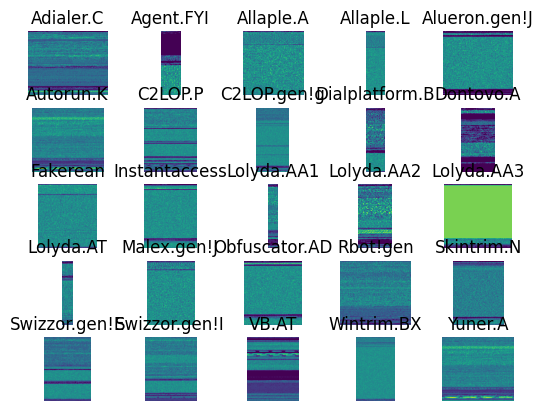

In [48]:
sample = get_stratified_sample(df2, 1, seed=444)

for i in range(len(sample)):
    entry = sample.iloc[i]
    family = entry['family']
    image = Image.open(entry['path'])
    
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(family)
    plt.axis('off')
plt.show()

In [49]:
# elegir el ancho y altura de cada imagen
px.scatter(df2, x="width", y="height", title="Ancho de las imágenes")

In [50]:
px.histogram(df2, x=df2["width"], title="Ancho de las imágenes")

In [51]:
px.histogram(df2, x=df2["height"], title="Alto de las imágenes")

In [ ]:
for _, row in df2.iterrows():
    os.makedirs(os.path.join(selected_images_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(selected_images_location, row['family'], row['name']))
    #os.symlink(row['path'], os.path.join(selected_images_location, row['family'], row['name']))

Para poder procesar las imagenes a entrenar podriamos eliminar el resto de imagenes, debido a que se esta utilizando un muestreo estratificado, no se estaran utilizando todas las imagenes, por lo que una solucion naive podria ser eliminar el resto de imagenes no utilizadas. Sin embargo si el random state del muestreo estratificado cambiase ya no podriamos utilizar algunas observaciones. Por lo que para ahorrar recursos y también para conservar todos los datos se realizó un folder adicional en donde para ahorrar recursos en vez de colocar copias de archivos, se colocarán symlinks

**Divida el dataset en un 70% entrenamiento y un 30% de pruebas.**

In [89]:
data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)

Found 2477 files belonging to 25 classes.


In [93]:
len(data)
# 78 batches totales de 2477 imagenes

78

In [91]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15


train = data.take(int(train_ratio * len(data)))
validation = data.skip(len(train)).take(int(validation_ratio * len(data)))
test = data.skip(len(train) + len(validation)).take(int(test_ratio * len(data)))

In [94]:
len(train), len(validation), len(test) 

(54, 11, 11)

Debido a como estan los datos se estan colocando en batches de imagenes en donde nosotros podemos ver que tenemos 54 batches para entrenamiento, 11 para testing y 11 para validación, en donde cada uno posee un aproximado de 32 imagenes por batch.

In [95]:
data.class_names

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

**Utilizando Keras y Tensorflow construya una red neuronal con las capas, funciones de activación y el optimizador que considere conveniente.**

In [97]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),     # normalize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(data.class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


**Muestre el resumen del modelo**

In [98]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

El modelo es una red neuronal convolucional que acepta imagenes de entrada de 256*256 pixeles y 3 canales de colores. En su primera capa normaliza los valores de entrada de los pixeles, en la capa Conv2D se relizan operaciones convolucionales para extraer caracteristicas las cuales son reducidas pero conservando informacion valiosa por por el MaxPooling2D, finalmente con la capa Flatten se convierten las caracteristicas a un vector de 1 dimensión lo cual se alimenta a una capa Dense con función de activación softmax que clasifica en distintas clases y retorna probabilidades dependiendo de las clases.

**Entrene el modelo con el número de épocas que considere conveniente.**

In [99]:
epochs=10
metrics = model.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/10
54/54 [==============================] - 30s 549ms/step - loss: 1.4839 - accuracy: 0.6291 - val_loss: 0.3852 - val_accuracy: 0.8722
Epoch 2/10
54/54 [==============================] - 30s 553ms/step - loss: 0.2909 - accuracy: 0.9097 - val_loss: 0.3631 - val_accuracy: 0.8835
Epoch 3/10
54/54 [==============================] - 29s 527ms/step - loss: 0.1648 - accuracy: 0.9439 - val_loss: 0.2378 - val_accuracy: 0.8920
Epoch 4/10
54/54 [==============================] - 28s 516ms/step - loss: 0.1075 - accuracy: 0.9641 - val_loss: 0.1651 - val_accuracy: 0.9006
Epoch 5/10
54/54 [==============================] - 28s 517ms/step - loss: 0.0446 - accuracy: 0.9878 - val_loss: 0.2365 - val_accuracy: 0.9403
Epoch 6/10
54/54 [==============================] - 28s 521ms/step - loss: 0.0247 - accuracy: 0.9954 - val_loss: 0.1411 - val_accuracy: 0.9517
Epoch 7/10
54/54 [==============================] - 28s 524ms/step - loss: 0.0149 - accuracy: 0.9965 - val_loss: 0.0933 - val_accuracy: 0.9716

**Muestre las métricas de su modelo.**

In [100]:
px.line(metrics.history, title="Métricas", labels={"value": "valor", "index": "época"})

Podemos ver las curvas de validación y entrenamiento tienden a converger ambas, por lo que tiende a un entrenamiento ideal con poco error irreducible, además nos indica que hay poca probabilidad a que haya un cesgo fuerte o un overfitting, por lo que el accuracy alto de 0.98 en el entrenamiento es indicador de que el modelo aprendió a clasificar bien las imagenes

**Evalúe el modelo con el dataset de pruebas y muestre las métricas obtenidas. Discuta los resultados obtenidos.**

In [101]:
loss, acc = model.evaluate(test)
print(f"{loss = }, {acc = }")

11/11 [==============================] - 2s 107ms/step - loss: 0.2263 - accuracy: 0.9432
loss = 0.22626185417175293, acc = 0.9431818127632141


In [102]:
probabilities = []
true_labels = []

for img_batch, label_batch in test:
    probability_batch = model.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch.numpy())

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

1/1 [==============================] - 0s 109ms/step


In [103]:
predicted_labels = np.argmax(probabilities, axis=-1)
predicted_labels

array([ 3, 17,  8,  7, 20,  2, 21, 13, 13,  3,  8, 12,  0,  3,  2, 16, 13,
       20, 19,  2, 11,  0,  7, 13, 10, 14, 14, 15,  3, 23, 15, 24,  5,  8,
       11, 14,  9,  8, 23,  4,  8, 14, 24, 10, 22,  2, 12, 11, 20,  9, 12,
       19, 20, 20, 20,  1, 23,  0,  5,  3, 17, 10, 18, 24, 18, 21, 24, 18,
       20, 23, 20,  5, 19, 18, 19,  8,  5,  4,  6, 14, 14, 20, 22,  1,  1,
        7,  6, 13, 17, 12, 19, 24,  8,  4,  3, 18, 24, 15, 11, 24,  6,  6,
       22,  0, 18,  8, 23, 18,  8,  1, 22,  3, 14, 24, 14, 15,  6,  9, 20,
       10, 10,  5, 10, 20, 18,  3,  8,  0, 10, 17, 20, 24, 20,  1,  9, 12,
       18,  3,  6, 24, 14,  7, 22,  9, 24, 12,  7, 11, 21, 22,  6, 16, 21,
       20, 16, 15, 16, 17,  1, 14,  6,  9, 20, 23,  1, 10, 20,  1, 24, 14,
        7, 11, 13, 20, 17, 15,  4, 24, 20, 24, 23, 11, 22, 12, 24,  4,  0,
       23, 24, 21, 20,  4, 24,  0, 21, 16,  2,  3, 14,  4, 17, 19,  3,  1,
       23, 12,  5, 12,  4,  0, 12, 20,  5, 17, 24,  2, 15,  6, 20, 23,  8,
        4,  9, 23,  3,  1

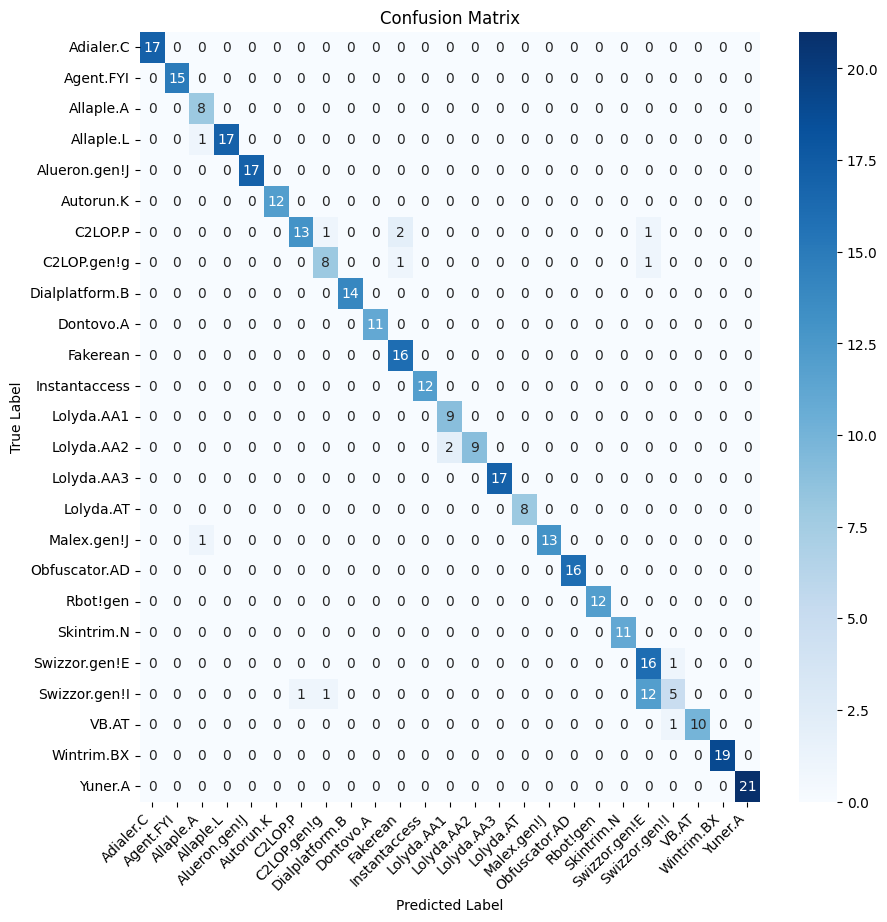

In [106]:

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=data.class_names, yticklabels=data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [105]:
class_report = classification_report(true_labels, predicted_labels, target_names=data.class_names)
print(class_report)

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        17
     Agent.FYI       1.00      1.00      1.00        15
     Allaple.A       0.80      1.00      0.89         8
     Allaple.L       1.00      0.94      0.97        18
 Alueron.gen!J       1.00      1.00      1.00        17
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       0.93      0.76      0.84        17
   C2LOP.gen!g       0.80      0.80      0.80        10
Dialplatform.B       1.00      1.00      1.00        14
     Dontovo.A       1.00      1.00      1.00        11
      Fakerean       0.84      1.00      0.91        16
 Instantaccess       1.00      1.00      1.00        12
    Lolyda.AA1       0.82      1.00      0.90         9
    Lolyda.AA2       1.00      0.82      0.90        11
    Lolyda.AA3       1.00      1.00      1.00        17
     Lolyda.AT       1.00      1.00      1.00         8
   Malex.gen!J       1.00      0.93      0.96  

Podemos ver que este modelo posee en general una presición promedio del 94% lo cual es un dato que nos indica que en un 94% de las veces basado en imagenes de malware, logra clasificar correctamente cual es dentro de los 25 tipos en los cuales se entrenó el malware. Si observamos las metricas más a detalle podemos ver que en un 72%  de las clases tiene una presición del 100%, esto nos indica que tiende a ser un modelo bastante bueno y que para los datos de prueba del 15% a dichas clases no se logra equivocar en la clasificación.   

  
Sin embargo debido a que el dataset de prueba era únicamente de 371 imagenes, no es una muestra representativa para poder decir que nunca se va a equivocar en la clasificación de esas 18 clases de malware, sin embargo con este conjunto de datos si podemos decir que es muy bueno clasificando estos tipos de malware.   
  
  
Además vemos que en las 7 clases restantes que no obtuvieron un 100% de presición, sin embargo, se obtienen medidas bastante buenas diciendonos que tiende a clasificar bastante bien el malware, no solo en presición sino que tambien en recall y f1-score, esto se ve reflejado en la medidas generales del modelo, con una sensibilidad del  del 0.93 y puntaje f1 de 0.93 diciendonos que en general el modelo logra predecir con exactitud las instancias verdaderas positivas de las 25 clases. 
  
  
Este modelo únicamente tuvo un desempeño pobre en las clases de malware Swizzor.gen!E y Swizzor.gen!I. En Swizzor.gen!E podemos ver que a pesar de que logre clasificar en un 94% de exactitud los verdaderos positivos de esta clase tiene una presición del 0.53 ya que no logra diferenciar entre la clase Swizzor.gen!I, por lo que tiende a afectar a ambos, siendo esto justificable ya que ambos son de una misma familia y si se clasificaran en una sola, tendrían un 94% de presición, por lo que podria recomendarse obtener más observaciones de ambas familias para que el modelo aprenda mejor las diferencias o clasificarlas como una sola.

Por lo que podemos decir que en general el modelo es muy bueno clasificando malware usando imagenes de bits y que puede llegar a tener un uso practico, sin embargo se recomienda probar con un dataset más grande y con distintos porcentajes de conjunto de prueba y validación.
